In [1]:
# imports
import json
import jsonlines
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from statistics import mean

In [ ]:
# for experiments with two features, two agents, and the following allocation mechanisms:
# baseline, fairness lottery, least fair, most compatible, product lottery, and static lottery
# the only necessary modifications are:
#   - choose whether to export dataframes as images (cell #3)
#   - change choice_type string (cell #4)
#   - change filepaths (cell #5)
# generates 21 to 23 vizualizations

In [36]:
# running this cell will save images of the NCDG & Proportional fairness tables
# it requires an additional import to do so
try:
    import dataframe_image as dfi
except:
    %pip install dataframe_image
    import dataframe_image as dfi
GENERATE_PANDAS_IMAGES = True

In [ ]:
# change choice_type to the appropriate choice mechanism to change image prefixez
choice_type = "choice"

In [48]:
# change these to the appropriate paths
BASELINE = '../data/history_file_baseline_2agents.json'
FAIRNESS_LOTTERY = '../data/history_file_fairness_lottery_2agents.json'
LEAST_FAIR = '../data/history_file_least_fair_2agents.json'
MOST_COMPATIBLE = '../data/history_file_most_compatible_2agents.json'
PRODUCT_LOTTERY = '../data/history_file_product_lottery_2agents.json'
STATIC_LOTTERY = '../data/history_file_static_lottery_2agents.json'

recs_file = '../data/recs.csv'
items_file = '../data/item.csv'

In [49]:
# reads recommender and item files
recommender = pd.read_csv(recs_file, names=["User","Item","Score"])
item_features = pd.read_csv(items_file, names=["Item","Feature","BV"])

In [44]:
# no need to change unless adding a new allocation mechanism
history_files = [BASELINE,FAIRNESS_LOTTERY,LEAST_FAIR,MOST_COMPATIBLE,PRODUCT_LOTTERY,STATIC_LOTTERY]

baseline = []
fairness_lottery = []
least_fair = []
most_compatible = []
product_lottery = []
static_lottery = []

list_names = [baseline,fairness_lottery,least_fair,most_compatible,product_lottery,static_lottery]
readable_names = ["Baseline","Fairness Lottery", "Least Fair", "Most Compatible", "Product Lottery", "Static Lottery"]

In [45]:
# define dictionaries for statistical analysis, change if adding new allocation mechanisms
results_baseline = {}
results_fairness_lottery = {}
results_least_fair = {}
results_most_compatible = {}
results_product_lottery = {}
results_static_lottery = {}

dict_names = [results_baseline,results_fairness_lottery,results_least_fair,results_most_compatible,results_product_lottery,results_static_lottery]

In [46]:
# read history files
for history_file, list_name in zip(history_files,list_names):
    with jsonlines.open(history_file) as reader:
        for obj in reader:
            list_name.append(obj)

In [7]:
# process history files into dictionaries for statistics
for list, dictionary in zip(list_names, dict_names):
    for line in list:
        results = line['choice_out']['results']
        results_list = []
        for item in results:
            results_list.append(item['item'])
        dictionary[line['user']] = results_list 

In [8]:
### STATISTICS FUNCTIONS ###

# get recommendation score based on user and item ids
def lookupscore(user, item):
    user = int(user)
    item = int(item)
    score = recommender.loc[(recommender.User == user) & (recommender.Item == item)]["Score"]
    return float(score)

# calculate ndcg given a list of recommended and ideal scores
def ndcg(scores1, scores2):
    idealdcg = 0.0
    recdcg = 0.0
    for index, val in enumerate(scores1): 
        recdcg += (2**val - 1)/np.log2(index + 2)
    for index, val in enumerate(scores2):
         idealdcg += (2**val - 1)/np.log2(index + 2)
    return recdcg/idealdcg

# not currently run in this file
def plot_ndcg(name,ndcg_results):
    ndcg_result = ndcg_results[name]
    ndcg_data = pd.DataFrame(ndcg_result)
    sb.lineplot(ndcg_data)
    imagefile = name + "ndcgplot.png"
    plt.savefig(imagefile)

# given an item id return a list of its features as binary values
def get_item_features(item_id):
    feature_values = []
    for value in item_features.loc[(item_features.Item == int(item_id))]["BV"]:
        feature_values.append(value)
    return feature_values
        

In [9]:
### VISUALIZATION FUNCTIONS ###
# TODO: Update viz functions to make them more efficient and inline with statistics

def process_history(history, fair=True, compat=True, alloc=True, lists=True):
    if fair:
        fair_list = [entry['allocation']['fairness scores'] for entry in history]
        fair_df = pd.DataFrame(fair_list)
    else:
        fair_df = None
    if compat:
        compat_list = [entry['allocation']['compatibility scores'] for entry in history]
        compat_df = pd.DataFrame(compat_list)
    else:
        compat_df = None
    if alloc:
        alloc_list = [entry['allocation']['output'] for entry in history]
        alloc_df = pd.DataFrame(alloc_list)
        alloc_df['none'] = (alloc_df['1'] == 0) & (alloc_df['2'] == 0)
    else:
        alloc_df = None
    if lists:
        results_list = [process_results(entry['choice_out']['results']) for entry in history]
    else:
        results_list = None
    return fair_df, compat_df, alloc_df, results_list

def process_results(result_structs):
    return [(entry['item'], entry['score']) for entry in result_structs]

def plot_fairness_time(experiment_data, include_none=False, image_prefix=None):

    fair_df = experiment_data[0]
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Fairness")
    sb.lineplot(data=fair_df)
    image_file = image_prefix + '-fairness.png'
    plt.savefig(image_file)

def plot_allocation(experiment_data, include_none=False, image_prefix=None):
    alloc_df = pd.DataFrame(experiment_data[2])
    if include_none is False:
        if not alloc_df['none'][1:].any():
            alloc_df.drop('none', axis=1, inplace=True)
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Allocation")
    sb.lineplot(data=alloc_df.cumsum())
    image_file = image_prefix + '-allocation.png'
    plt.savefig(image_file)

def plot_fairness_regret(experiment_data, include_none=False, image_prefix=None):

    fair_df = experiment_data[0]
    regret = 1-fair_df
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Fairness Regret")
    sb.lineplot(data=regret.cumsum())
    image_file = image_prefix + '-regret.png'
    plt.savefig(image_file)

def do_plots(experiment_data, include_none=False, image_prefix=None):
    plot_fairness_time(experiment_data, include_none, image_prefix)
    plot_allocation(experiment_data, include_none, image_prefix)
    plot_fairness_regret(experiment_data, include_none, image_prefix)

def process(experiment, include_none=False, image_prefix=None):
    experiment_data = process_history(experiment)
    do_plots(experiment_data, include_none, image_prefix)


In [10]:
# generates average NDCG for each allocation mechanism and stores them in the list avg_of_ndcg
# also creates ndcg_results, a dictionary that allows plotting NDCG over time for each mechanism
avg_of_ndcg = []
ndcg_results = {}
for dictionary, name in zip(dict_names, readable_names):
    users = []
    ndcg_values = []
    for user, items in dictionary.items():
        scores = []
        for item in items:
            scores.append(lookupscore(user, item))
        ideal_scores = []
        for score in recommender.loc[(recommender.User == int(user))]["Score"].sort_values(ascending=False):
            ideal_scores.append(score)
            ideal_scores = ideal_scores[0:len(scores)+1]
        ndcg_values.append(ndcg(scores, ideal_scores))
        users.append(user)
    avg_of_ndcg.append(mean(ndcg_values))
    ndcg_results[name] = {"Users":users, "NDCG":ndcg_values}

In [40]:
# creates dataframe of average NDCG values
ndcg_table = pd.DataFrame(data=avg_of_ndcg, index=readable_names, columns=["NDCG"])
ndcg_table

,NDCG
Baseline,0.961873
Fairness Lottery,0.835147
Least Fair,0.830959
Most Compatible,0.898346
Product Lottery,0.838879
Static Lottery,0.877943


In [12]:
# calculates proportional fairness for the representation of item features
# currently designed to handle two item features
# TODO: make it easier to change number of item features
either_fairness = []
f1_representation = []
f2_representation = []

for dictionary, name in zip(dict_names, readable_names):
    item_counter = 0
    f0 = 0
    f1 = 0
    f2 = 0
    either = 0
    for items in dictionary.values():
        for item in items:
            item_counter += 1
            list_of_features = get_item_features(item)
            if list_of_features[0] == 1:
                f0 += 1
            if list_of_features[1] == 1:
                f1 += 1
            if list_of_features[2] == 1:
                f2 += 1
            if list_of_features[1] == 1 or list_of_features[2] == 1:
                either += 1
    either_fairness.append(either/item_counter)
    f1_representation.append(f1/item_counter)
    f2_representation.append(f2/item_counter)

In [13]:
fairness_results = {"Protected":either_fairness,"1":f1_representation,"2":f2_representation}
prop_fairness_results = pd.DataFrame(data=fairness_results, index=readable_names)
prop_fairness_results

,Protected,1,2
Baseline,0.964,0.570,0.890
Fairness Lottery,0.988,0.788,0.900
Least Fair,0.986,0.818,0.882
Most Compatible,0.994,0.642,0.960
Product Lottery,0.988,0.784,0.898
Static Lottery,0.986,0.672,0.922


In [14]:
# process history files for visualizations
# TODO: identify necessary features & streamline this process 
fair_df_baseline, compat_df_baseline, alloc_df_baseline, results = process_history(baseline)
fair_df_fairness_lottery, compat_df_fairness_lottery, alloc_df_fairness_lottery, results = process_history(fairness_lottery)
fair_df_least_fair, compat_df_least_fair, alloc_df_least_fair, results = process_history(least_fair)
fair_df_most_compatible, compat_df_most_compatible, alloc_df_most_compatible, results_most_compatible = process_history(most_compatible)
fair_df_product_lottery, compat_df_product_lottery, alloc_df_product_lottery, results_product_lottery = process_history(product_lottery)
fair_df_static_lottery, compat_df_static_lottery, alloc_df_static_lottery, results_static_lottery = process_history(static_lottery)
        

In [15]:
# create DF of fairness values
# streamline as part of above visualization overhaul
fair_df = pd.DataFrame()
fair_df.loc[:,'Baseline'] = fair_df_baseline.sum(axis=1)
fair_df.loc[:,'Fairness Lottery'] = fair_df_fairness_lottery.sum(axis=1)
fair_df.loc[:,'Least Fair'] = fair_df_least_fair.sum(axis=1)
fair_df.loc[:,'Most Campatible'] = fair_df_most_compatible.sum(axis=1)
fair_df.loc[:,'Product Lottery'] = fair_df_product_lottery.sum(axis=1)
fair_df.loc[:,'Static Lottery'] = fair_df_static_lottery.sum(axis=1)

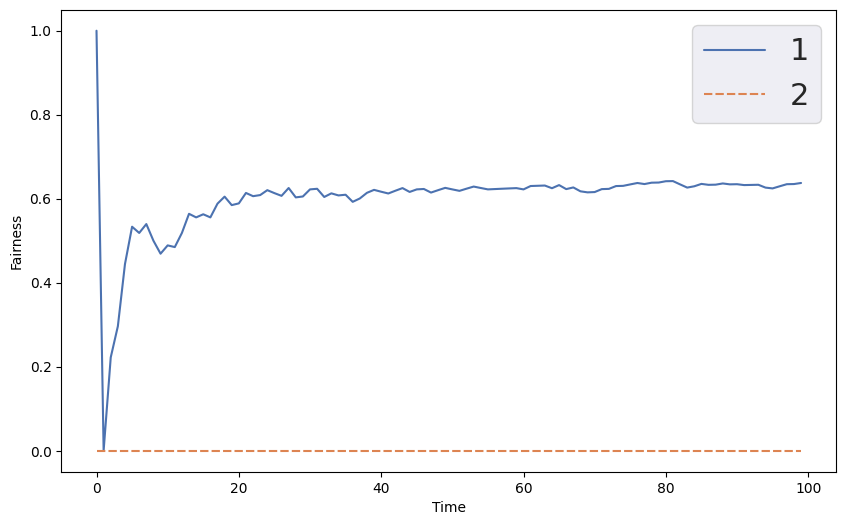

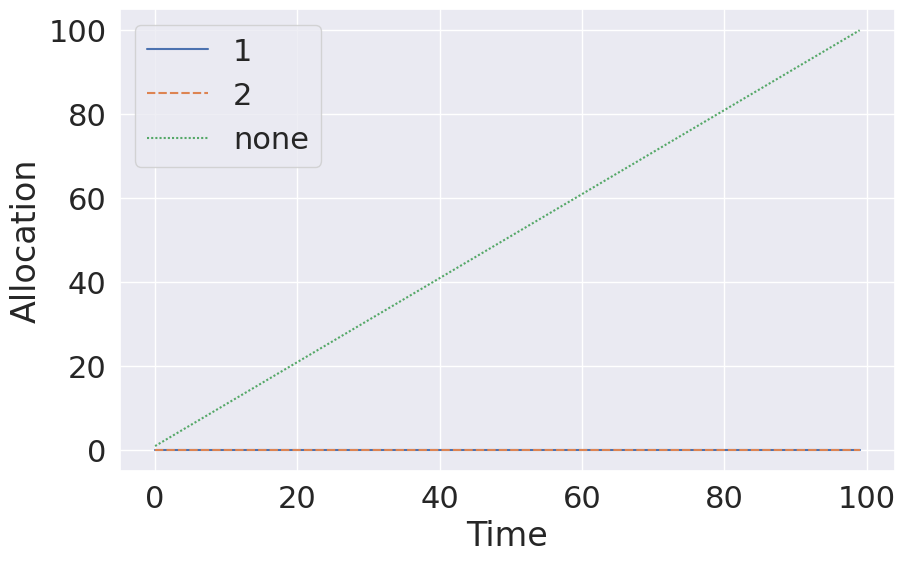

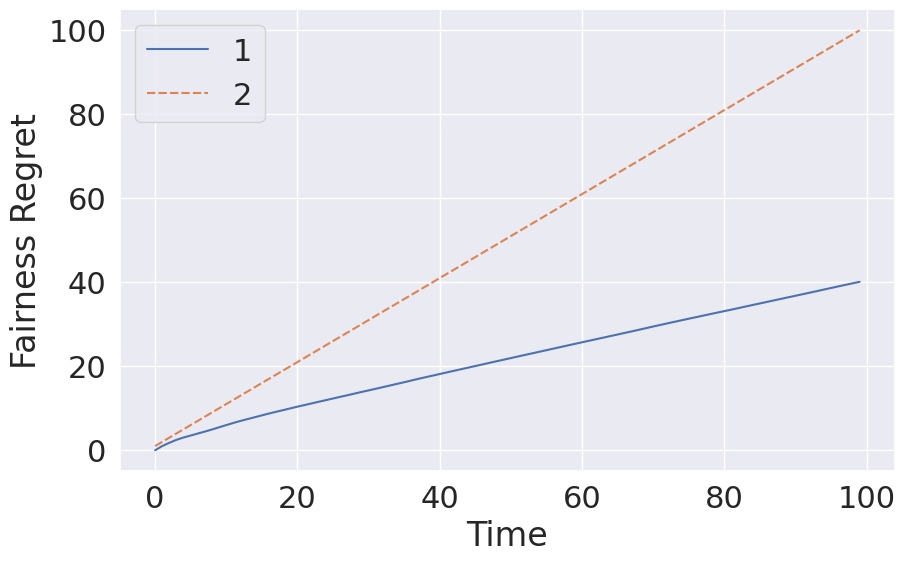

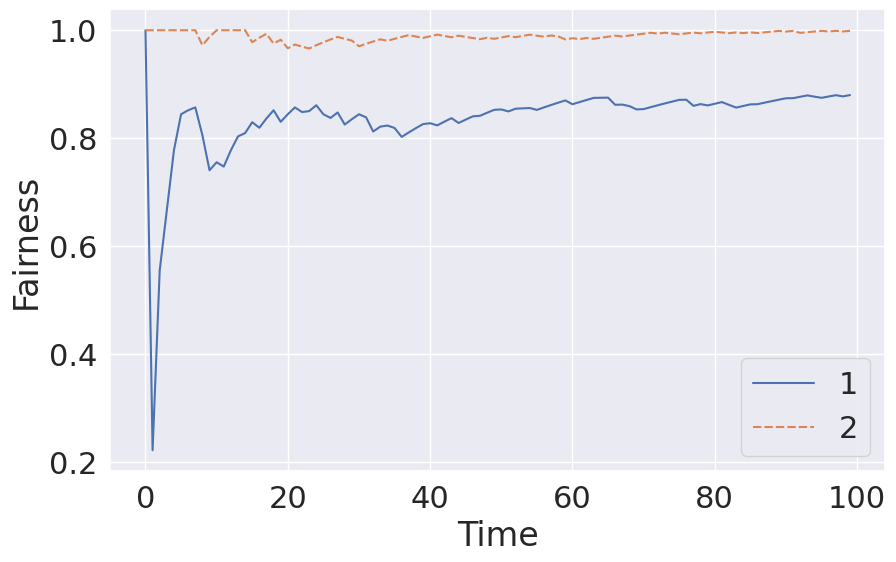

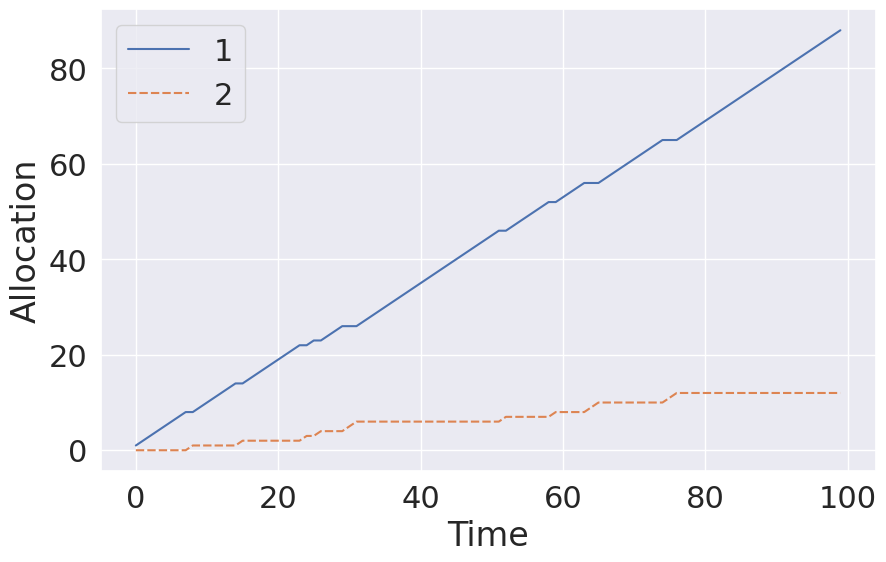

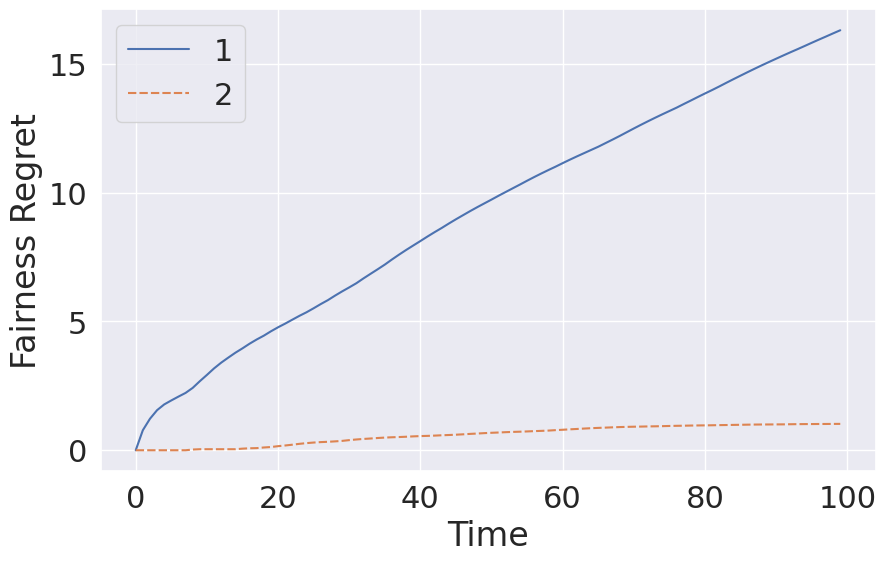

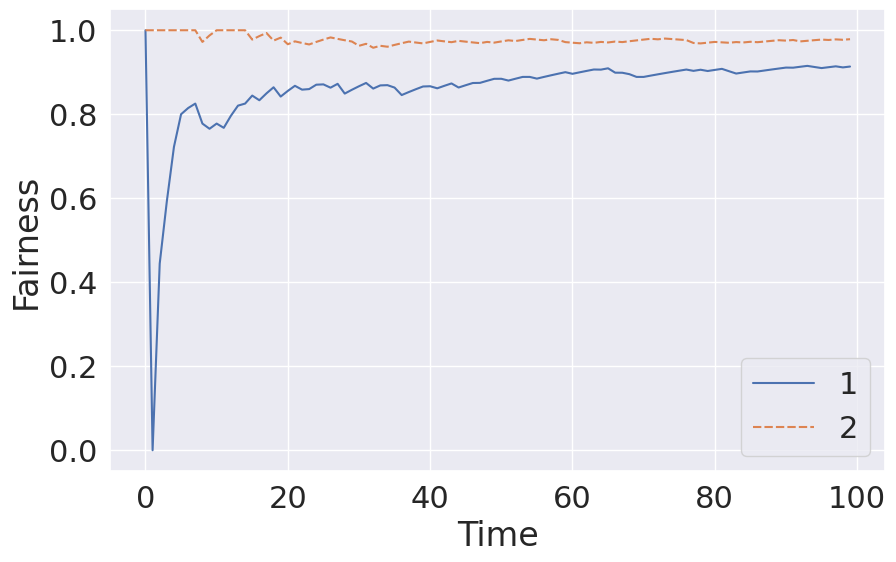

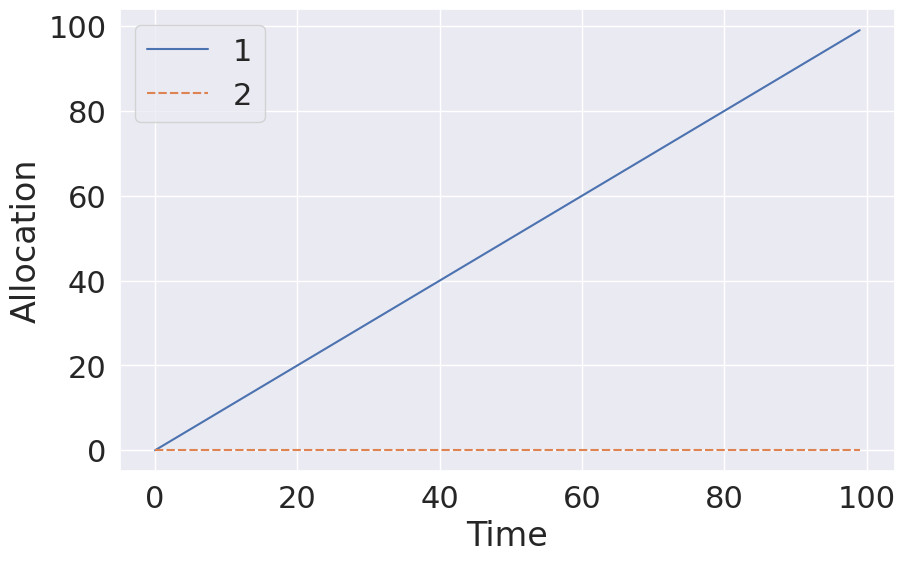

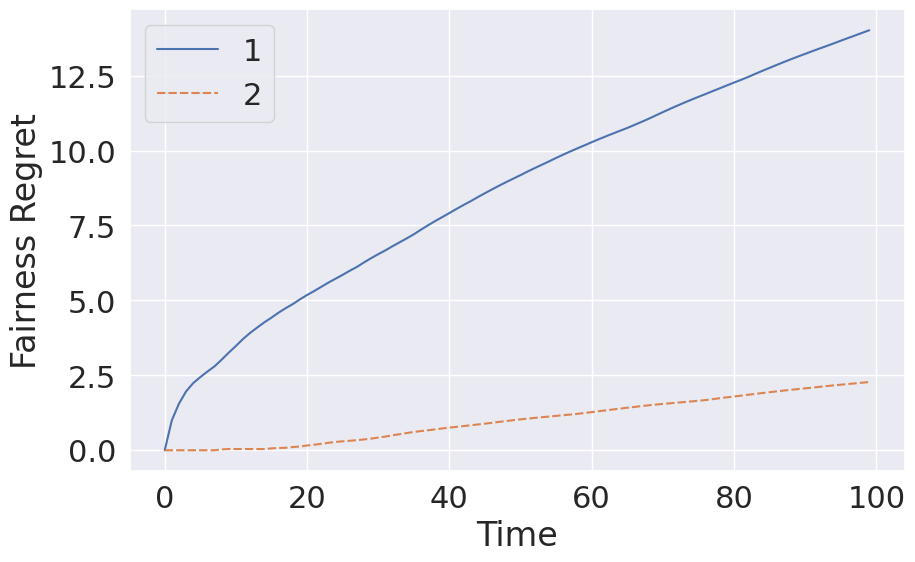

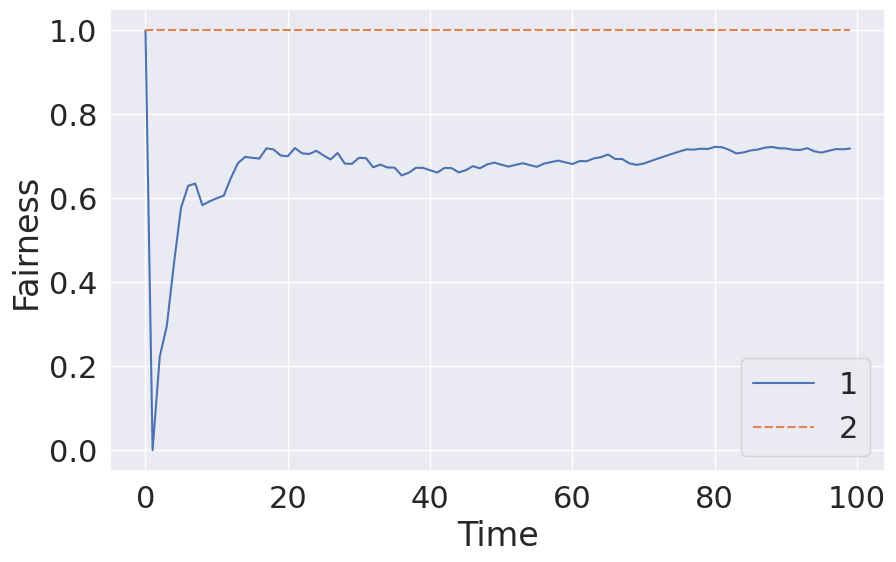

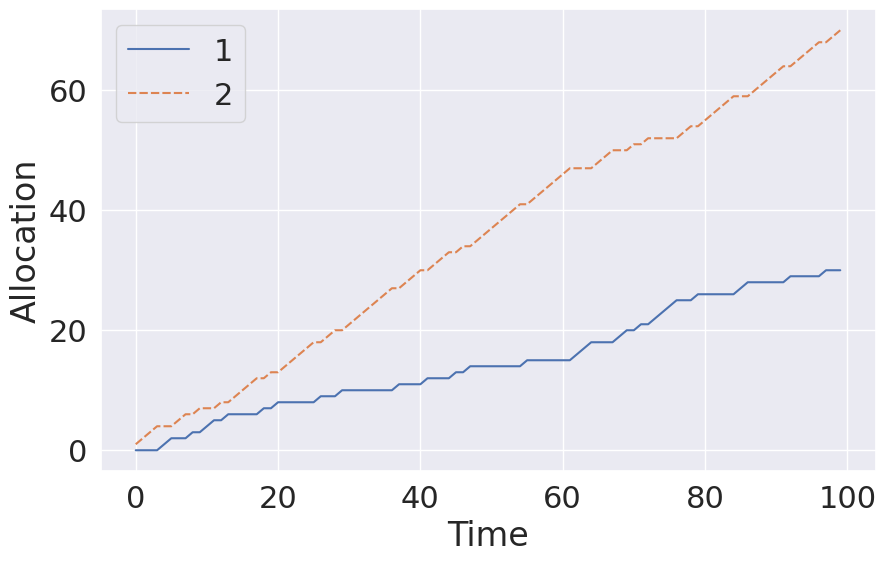

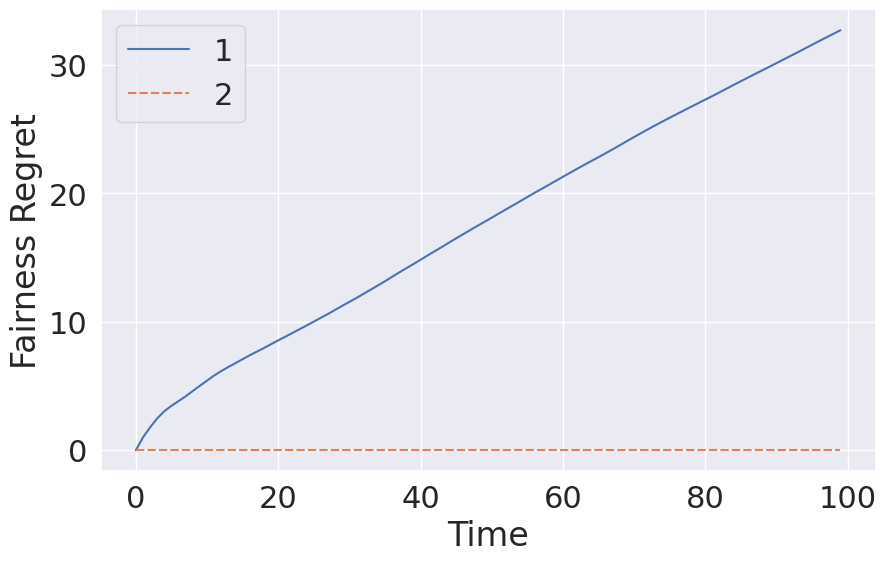

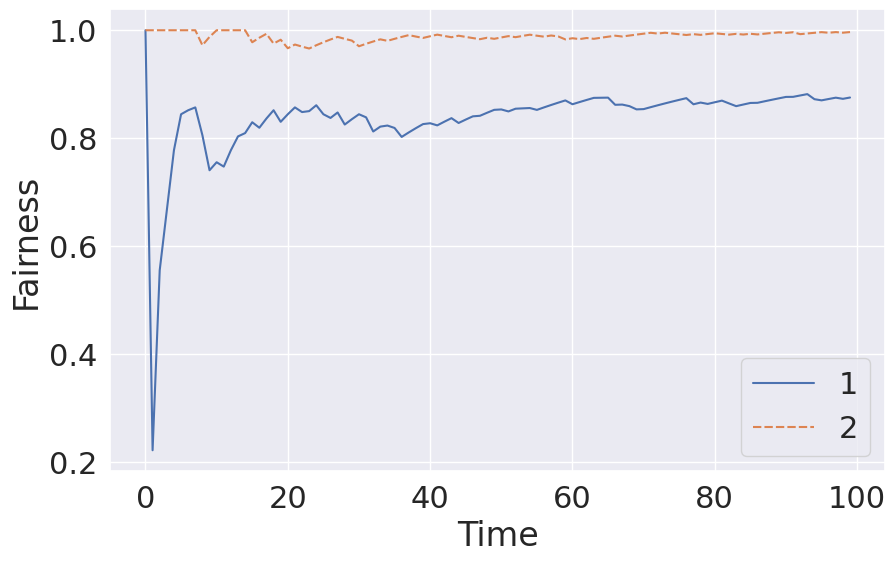

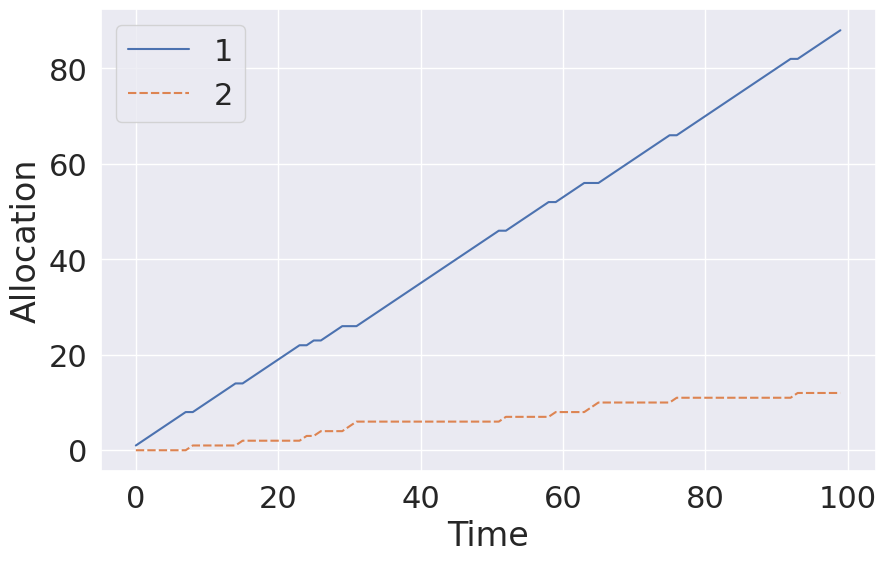

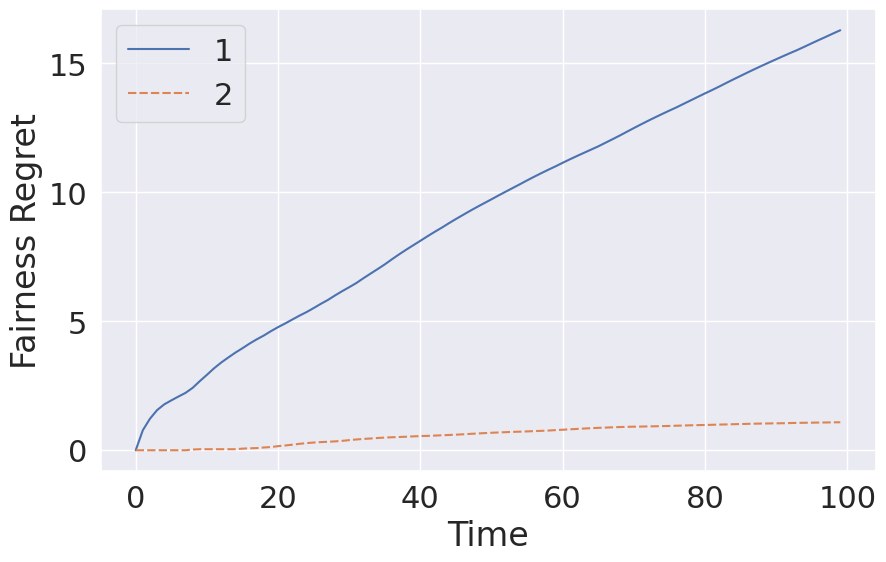

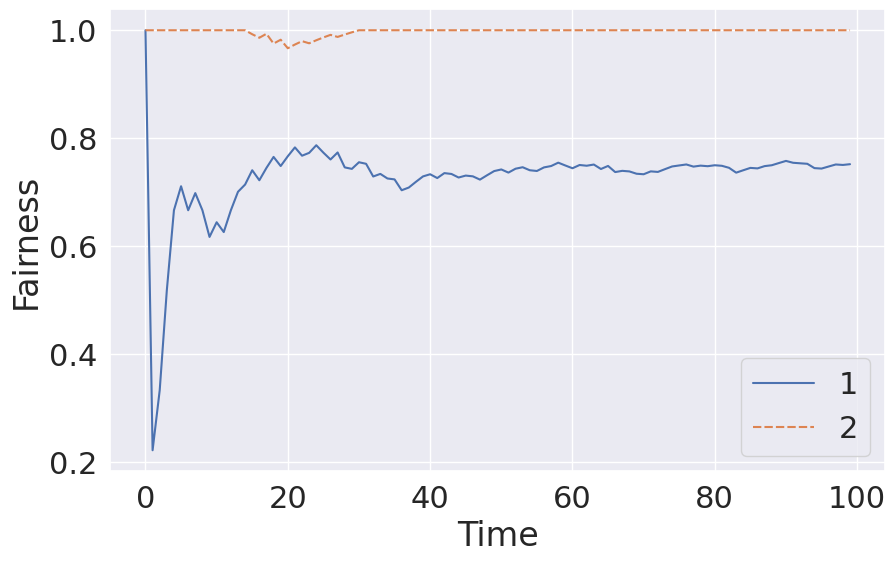

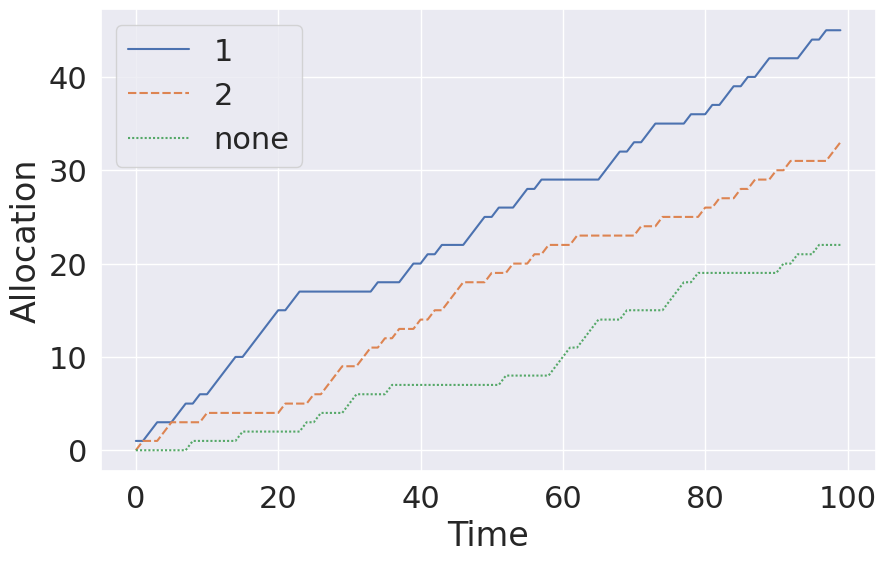

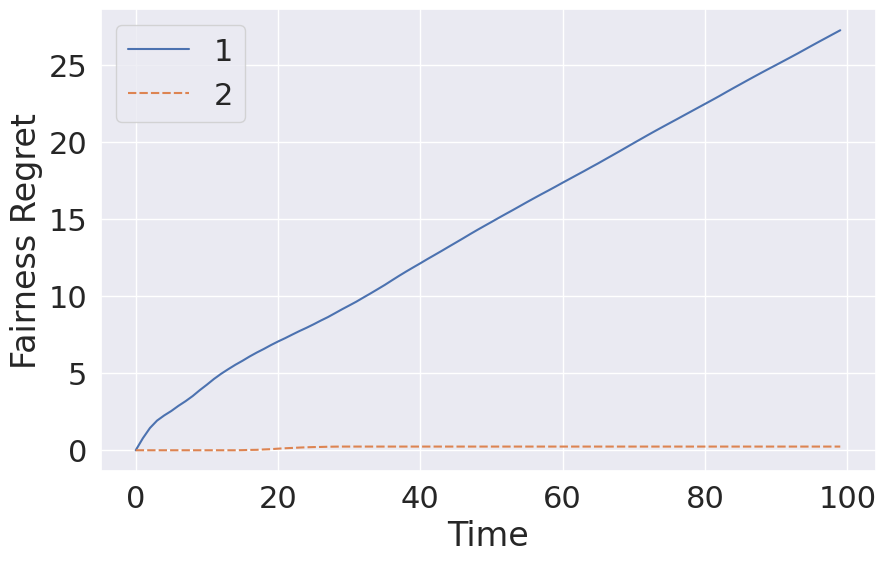

In [16]:
# generate individual visualizations for allocation mechanisms
for list, name in zip(list_names,readable_names):
    prefix = choice_type + "-" + name.lower().replace(" ","_")
    process(list, image_prefix=prefix)

In [27]:
# create a DataFrame of regret values to visualize all mechanisms together
# update line 6 if there are more than two agents
# TODO: change function order, creation of sum to handle more than two agents
regrets = []
for mechanism, name in zip(list_names, readable_names):
    fair_df = process_history(mechanism)[0]
    regret = 1-fair_df
    regret["Allocation"] = name
    regret["Sum"] = regret["1"]+regret["2"]
    for row_num in range(len(regret)):
        regret.loc[row_num, "Agent 1 Regret"] = regret.loc[0:row_num, "1"].sum()
        regret.loc[row_num, "Agent 2 Regret"] = regret.loc[0:row_num, "2"].sum()
        regret.loc[row_num, "Total Regret"] = regret.loc[0:row_num, "Sum"].sum()
    regrets.append(regret)
regret_all = pd.concat(regrets, axis=0)

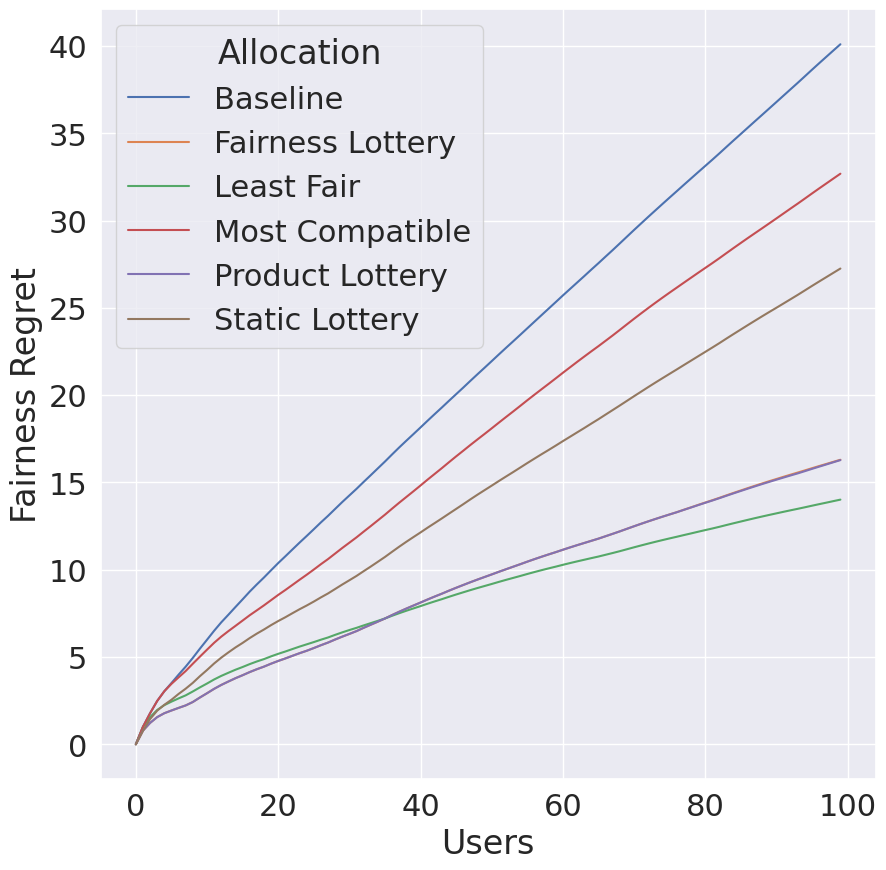

In [32]:
plt.subplots(figsize=(10, 10))
plt.xlabel("Users")
plt.ylabel("Fairness Regret")
sb.lineplot(x=regret_all.index,y=regret_all["Agent 1 Regret"], hue=regret_all["Allocation"])
savename = choice_type + "-all-regret-agent1.png"
plt.savefig(savename)

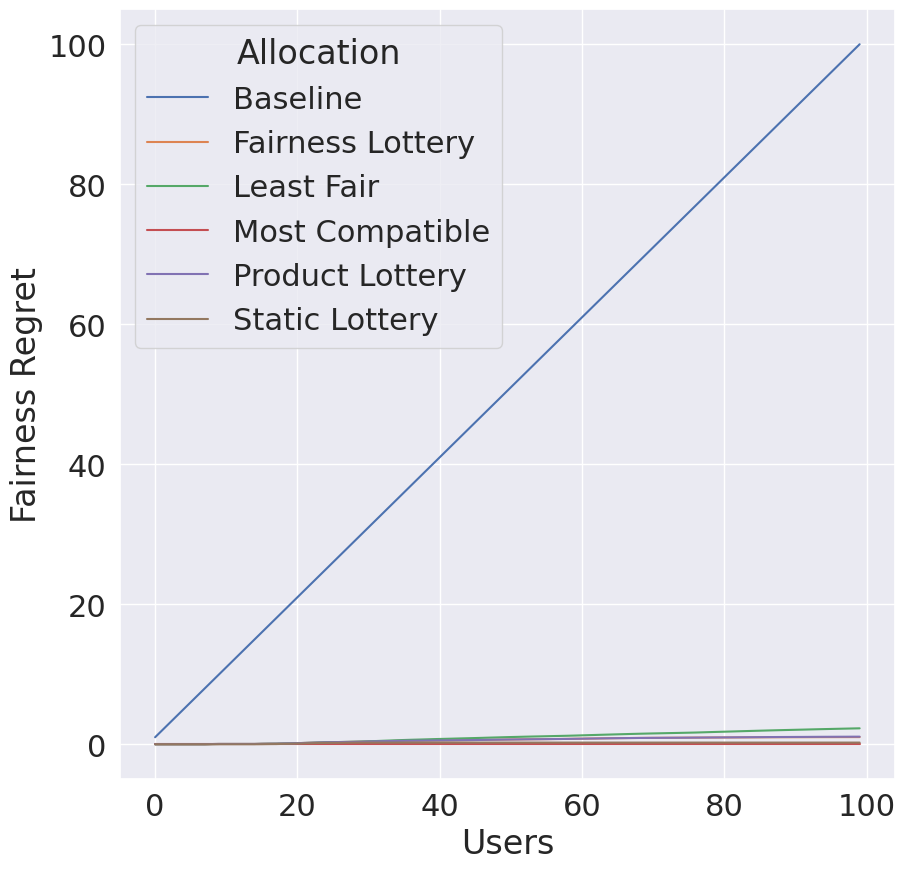

In [33]:
plt.subplots(figsize=(10, 10))
plt.xlabel("Users")
plt.ylabel("Fairness Regret")
sb.lineplot(x=regret_all.index,y=regret_all["Agent 2 Regret"], hue=regret_all["Allocation"])
savename = choice_type + "-all-regret-agent2.png"
plt.savefig(savename)

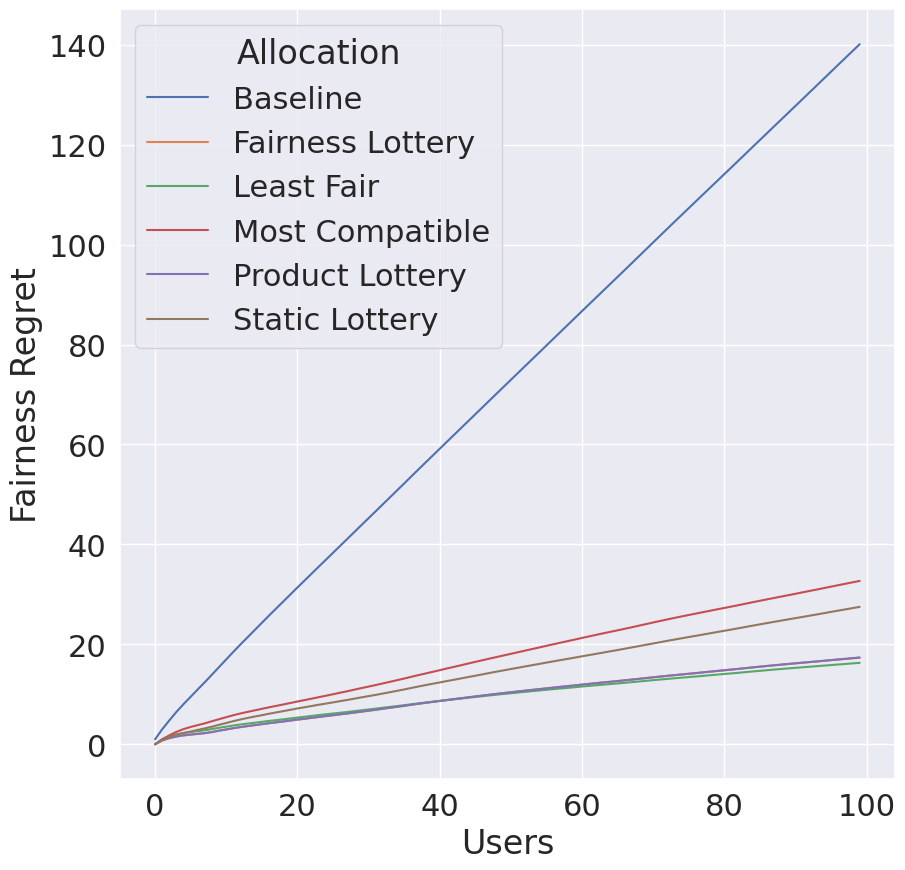

In [34]:
plt.subplots(figsize=(10, 10))
plt.xlabel("Users")
plt.ylabel("Fairness Regret")
sb.lineplot(x=regret_all.index,y=regret_all["Total Regret"], hue=regret_all["Allocation"])
savename = choice_type + "-all-regret-sum.png"
plt.savefig(savename)

In [ ]:
ndcg_table

In [ ]:
prop_fairness_results

In [41]:
# may return error: Chrome executable not able to be found on your machine
# if this happens, add a chrome_path parameter with a path to Google Chrome on your machine
#   Ex.
#       dfi.export(df, name, chrome=path="/Users/Applications/Google Chrome")
if GENERATE_PANDAS_IMAGES:
    dfi.export(ndcg_table, choice_type+"-ndcg_table.png")
    dfi.export(prop_fairness_results, choice_type+"-proportional_fairness_table.png")

                      NDCG
Baseline          0.961873
Fairness Lottery  0.835147
Least Fair        0.830959
Most Compatible   0.898346
Product Lottery   0.838879
Static Lottery    0.877943
                  Protected      1      2
Baseline              0.964  0.570  0.890
Fairness Lottery      0.988  0.788  0.900
Least Fair            0.986  0.818  0.882
Most Compatible       0.994  0.642  0.960
Product Lottery       0.988  0.784  0.898
Static Lottery        0.986  0.672  0.922
